# Single Kernel Programming using Stream or Memory Interface

This lab is the most fundamental module of the entire AI Engine data movement and interconnection tutorial, much like a building block for Multiple Kernel Programming. It demonstrates the basic construction of a single kernel using memory and stream interfaces for a basic mean filtering kernel.

1. When using the buffer, data transfers can be realized as ping-pong buffers or optionally, using a single buffer. The AI Engine tools will take care of buffer synchronization between the kernels. Designers need to decide the buffer size and optionally buffer location between kernels when partitioning the application. If an overlap is needed between different buffers of the data, the AI Engine tools provide options for setting a margin for the buffer, that is, to copy the overlap of data automatically.

2. When using streams, the data movement involves two input as well as two output stream ports, along with one dedicated cascade stream input port and output port. Stream ports can provide 32-bit per cycle or, 128-bit per four cycles on each port. Stream interfaces are bidirectional and can read or write neighboring or non-neighboring AI Engines by stream ports. However, cascade stream ports are unidirectional and only provide a one-way access between the neighboring AI Engines.

The following figure shows the diagram of this lab.

<img src="./image//stream_memory.png" alt="stream_memory Image" width="500" height="170">


## Step 0: AIE Data Flow Graph Analysis

The connection can be switched between stream and window buffer by commenting the line 12 in the graph.hpp file which changes the mario definition.
```
//#define STREAM

#ifdef STREAM
#define CONNECTION stream
#else
#define CONNECTION window< NUM_SAMPLES * NBYTES_DATA >
#endif
```

### 1. Memory Interface

Buffer ports provide a way for a kernel to operate on a block of data. Buffer ports operate in single direction (e.g., input or output). The view that a kernel has of incoming blocks of data is called an input buffer.

When a kernel has a buffer port on its input side, it waits for the buffer to be fully available before it starts execution. The kernel can access the contents of the buffer port either randomly or in a linear fashion. Conversely the kernel can write a block (frame) of data to the local memory that can be used by other kernels after it has finished execution. When an AI Engine kernel uses memory interfaces, it must acquire a lock to gain access ownership to this memory. Lock acquisition and release takes a minimum of seven cycles per lock, which reduces the time allowed for processing.

This following figure is the memory interface version of the AIE graph, array mapping and emulation trace view in Vitis Analyzer which lists the events and their dependencies:

<img src="./image/all_b.png" alt="Stream Image" width="1100" height="550">

1: Tile 24_1 DMA s2mm channel 0 (s2mm.Ch0.BD0.lock0) starts. It acquires the lock of ping of input buffer (buf0) to fir_asym_8t_16int_window and transfers data from the PL to buf0. Refer to Graph View for the position of the buffer in the graph.

2: After DMA s2mm channel 0 BD 0 completes, DMA s2mm channel 0 BD 1 (s2mm.CH0.BD1.lock1) starts. It acquires the lock of pong of input buffer (buf0d) and transfers data from the PL to buf0d.

3a: The fir_asym_8t_16int_window kernel (in tile 24_0) acquires the lock of buf0 (shown as read lock allocated).

3b: fir_asym_8t_16int_window kernel acquires the lock of ping of output buffer (buf1) as well.

4a: After fir_asym_8t_16int_window kernel acquires the locks of its input buffer (buf0) and output buffer (buf1), it starts. If any lock cannot be acquired, it will run into lock stall.

4b: After tile 24_1 DMA s2mm channel 0 BD 1 (s2mm.CH0.BD1.lock1) completes, it switches back to DMA s2mm channel 0 BD 0 (s2mm.CH0.BD0.lock0). After the read lock of the buffer is released, it acquires the lock and starts data transfer from PL.

5a: After fir_asym_8t_16int_window kernel completes, it releases the write lock allocated output buffer (buf1) and switches into the read lock allocated status.

5b: After the lock of output buffer (buf1) is read locked, the tile 24_0 DMA mm2s channel 0 BD 1 (mm2s.CH0.BD0.lock0) starts the data transfer from AIE to PL.

### 2. Stream Interface

The bandwidth of the memory (where windows are stored) access is much higher than the streams: 2x32 GBps vs. 2x4 GBps. Even if the memory bandwidth from the processor is high, they must be filled in either by another AI Engine (bandwidth 32 GBps) or streams (2x4GBps). To achieve the maximum performance filter implementation, streaming interface can be used at the input and the output. The data register is limited to 1024 bits (aie::vector<cint16, 32>) and the coefficient register maximum bitwidth is 512 bits (aie::vector<cint16, 16>). Having a streaming interface (single stream to start with), four cint16 can be read in one instruction, but it takes four clock cycles to be able to perform the same operation again.

This following figure is the stream interface version of the AIE graph, array mapping and emulation trace view in Vitis Analyzer which lists the events and their dependencies:

<img src="./image/all_s.png" alt="Stream Image" width="1100" height="550">

## Step 1: Generate a Complex Signal Data with High-Frequency Noise

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import kaiserord, lfilter, firwin, freqz

import sys
sys.path.append('../../../../common')
from aie_signals import SignalPlotter
from aie_signals import SignalGenerator
from aie_file import FileGen

sample_rate = 100.0
nsamples = 1024

# Plot the the signal
signal, time = SignalGenerator.generate_real(nsamples, sample_rate)
FileGen.vector2file_int16(signal, './data/input.txt', scale=True)
AIE_input_signal = FileGen().read_int16('./data/input.txt', 1024)

# Write the signal_array to a header file
header_file_path = './data/signal_data.h'
data_type = 'int16_t'
FileGen.array2header(AIE_input_signal, data_type, header_file_path)

## Step 2: Mean Filter Software Implementation using lfilter

8.0


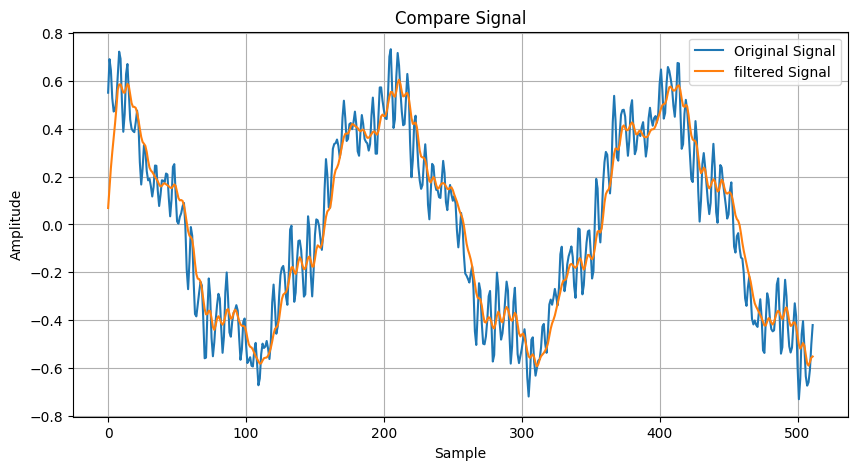

In [6]:
window_size = 8
coefficients = np.ones(window_size)
coeffs_sum = np.sum(coefficients)
print(coeffs_sum)
smoothed_signal = lfilter(coefficients, window_size, signal)

# Plot the original signal and the smoothed signal

plotter = SignalPlotter(signal,smoothed_signal)
plotter.compare_signal(512)

## Step 3: Mean Filter AIE Emulation - Buffer Interface

AIE filtered signal


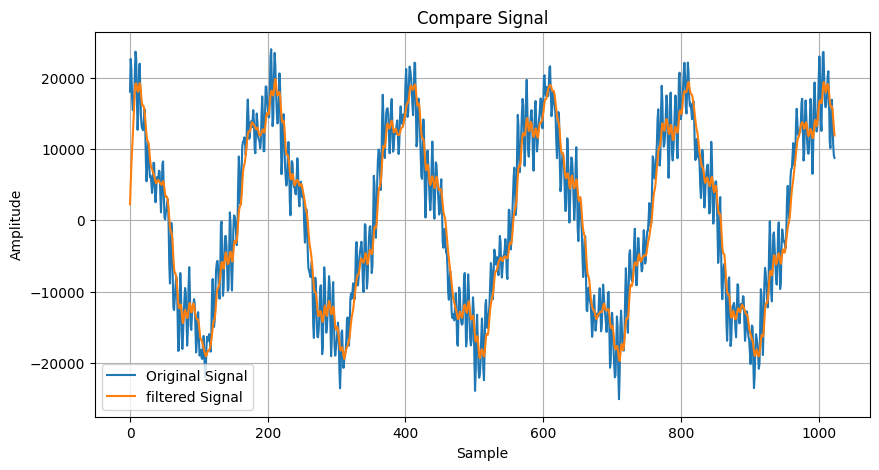

In [14]:
print("AIE filtered signal")
AIE_emulation_signal = FileGen().read_int16('./data/output_window.txt', 1024)

plotter = SignalPlotter(AIE_input_signal,AIE_emulation_signal)
plotter.compare_signal(1024)

## Step 4: Mean Filter AIE Emulation - Stream Interface


AIE filtered signal


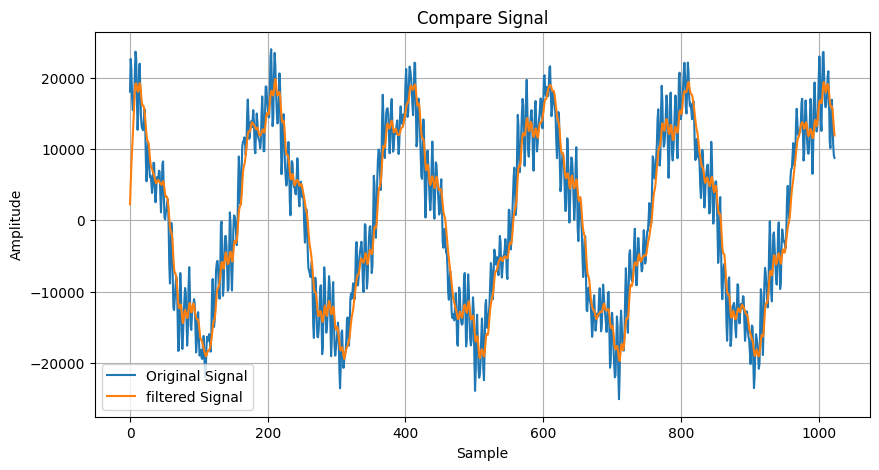

In [13]:
print("AIE filtered signal")
AIE_emulation_signal = FileGen().read_int16('./data/output_stream.txt', 1024)

plotter = SignalPlotter(AIE_input_signal,AIE_emulation_signal)
plotter.compare_signal(1024)

## Step 5: System Implementation for Hardware Execution

AIE System filtered signal


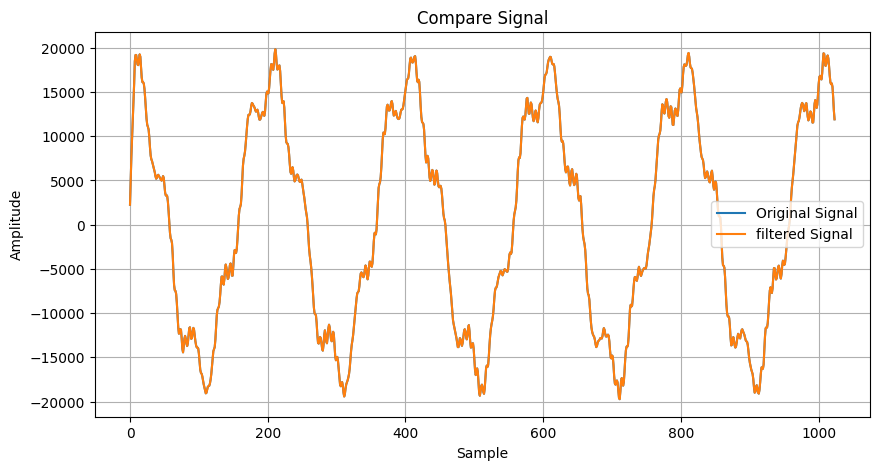

In [15]:
print("AIE System filtered signal")
hardware_signal = FileGen().read_int16('./data/output_host.txt', 1024)
FileGen.vector2file_int16(hardware_signal, './data/golden.txt', scale=True)

plotter = SignalPlotter(hardware_signal, AIE_emulation_signal)
plotter.compare_signal(1024)

-------------
<center>

Copyright&copy; 2023 AMD, Inc

SPDX-License-Identifier: MIT

</center>